# HR Analytics - Predict Employee Attrition

In [1]:
data_path = "C:/Users/vpriy/Downloads/HR_Analytics.csv"
data_path

'C:/Users/vpriy/Downloads/HR_Analytics.csv'

In [2]:
RANDOM_STATE = 42

In [3]:
#Importing librarys
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, f1_score
)


In [4]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Make folders for outputs
os.makedirs("reports", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

In [6]:
# 1) Load data
df = pd.read_csv(data_path)
print("Data shape:", df.shape)
display(df.head())

Data shape: (1480, 38)


,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,3,80,0,0,2,3,0,0,0,0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,1,80,0,0,2,3,0,0,0,0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,4,80,0,0,3,3,0,0,0,0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,4,80,0,0,2,3,0,0,0,0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,4,80,0,0,0,3,0,0,0,0


In [7]:
# 2) Quick column housekeeping
# Drop constant / useless / identifier columns if present
drop_candidates = ["EmployeeCount", "Over18", "StandardHours", "EmpID", "EmployeeNumber"]
for c in drop_candidates:
    if c in df.columns:
        # For standard/stat columns we drop if constant; for IDs we drop anyway.
        if c in ["EmployeeCount", "Over18", "StandardHours"]:
            if df[c].nunique() <= 1:
                df.drop(columns=[c], inplace=True)
        else:
            df.drop(columns=[c], inplace=True)

In [8]:
df

,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,3,...,3,3,0,0,2,3,0,0,0,0
1,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,4,...,3,1,0,0,2,3,0,0,0,0
2,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,2,...,3,4,0,0,3,3,0,0,0,0
3,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,2,...,3,4,0,0,2,3,0,0,0,0
4,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,3,...,3,4,0,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,60,55+,No,Travel_Rarely,422,Research & Development,7,3,Life Sciences,1,...,3,4,0,33,5,1,29,8,11,10
1476,60,55+,No,Travel_Frequently,1499,Sales,28,3,Marketing,3,...,3,4,0,22,5,4,18,13,13,11
1477,60,55+,No,Travel_Rarely,1179,Sales,16,4,Marketing,1,...,3,4,0,10,1,3,2,2,2,2
1478,60,55+,No,Travel_Rarely,696,Sales,7,4,Marketing,2,...,3,2,1,12,3,3,11,7,1,9


In [9]:
# Ensure target exists and map to binary
if "Attrition" not in df.columns:
    raise ValueError("No Attrition column found. Make sure it exists as Yes/No.")
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0}).astype(int)

In [10]:
df

,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,18,18-25,1,Travel_Rarely,230,Research & Development,3,3,Life Sciences,3,...,3,3,0,0,2,3,0,0,0,0
1,18,18-25,0,Travel_Rarely,812,Sales,10,3,Medical,4,...,3,1,0,0,2,3,0,0,0,0
2,18,18-25,1,Travel_Frequently,1306,Sales,5,3,Marketing,2,...,3,4,0,0,3,3,0,0,0,0
3,18,18-25,0,Non-Travel,287,Research & Development,5,2,Life Sciences,2,...,3,4,0,0,2,3,0,0,0,0
4,18,18-25,1,Non-Travel,247,Research & Development,8,1,Medical,3,...,3,4,0,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,60,55+,0,Travel_Rarely,422,Research & Development,7,3,Life Sciences,1,...,3,4,0,33,5,1,29,8,11,10
1476,60,55+,0,Travel_Frequently,1499,Sales,28,3,Marketing,3,...,3,4,0,22,5,4,18,13,13,11
1477,60,55+,0,Travel_Rarely,1179,Sales,16,4,Marketing,1,...,3,4,0,10,1,3,2,2,2,2
1478,60,55+,0,Travel_Rarely,696,Sales,7,4,Marketing,2,...,3,2,1,12,3,3,11,7,1,9


In [11]:
# 3) Basic missing handling + split features
# Separate X/y
y = df["Attrition"]
X = df.drop(columns=["Attrition"])

In [12]:
# Identify numeric/categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

In [13]:
num_cols

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [14]:
cat_cols

['AgeGroup',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'SalarySlab',
 'OverTime']

In [15]:
# Fill missing: numeric -> median, categorical -> "Unknown"
for c in num_cols:
    X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    X[c] = X[c].fillna("Unknown")

In [16]:
print(df.isnull().sum().sum(), "missing values remain.")

0 missing values remain.


In [17]:
print("Numeric cols:", len(num_cols), num_cols[:10])
print("Categorical cols:", len(cat_cols), cat_cols[:10])

Numeric cols: 23 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome']
Categorical cols: 9 ['AgeGroup', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'SalarySlab', 'OverTime']


# Feature Engineering

In [18]:
# Add Tenure bands if YearsAtCompany exists
if "YearsAtCompany" in X.columns:
    X["TenureBand"] = pd.cut(
        X["YearsAtCompany"],
        bins=[-1, 1, 3, 5, 10, 100],
        labels=["0-1", "1-3", "3-5", "5-10", "10+"]
    ).astype(str)

In [19]:
# RecentPromotion flag
if "YearsSinceLastPromotion" in X.columns:
    X["RecentPromotion"] = (X["YearsSinceLastPromotion"] <= 2).astype(int)

In [20]:
# Pay relative to role median (if both MonthlyIncome and JobRole present)
if ("MonthlyIncome" in X.columns) and ("JobRole" in X.columns):
    role_med = X.groupby("JobRole")["MonthlyIncome"].transform("median").replace(0, 1)
    X["PayToRoleMedian"] = X["MonthlyIncome"] / role_med

In [21]:
# Overtime numeric flag
if "OverTime" in X.columns:
    X["OverTimeFlag"] = X["OverTime"].apply(lambda v: 1 if str(v).strip().lower() in ("yes","y","true","1") else 0)

In [22]:
# Update column lists after engineering
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print("After FE -> numeric:", len(num_cols), "categorical:", len(cat_cols))

After FE -> numeric: 26 categorical: 10


# Exploratory Data Analysis

In [23]:
# Attrition rate
attr_rate = y.mean()
print(f"Overall attrition rate: {attr_rate:.3f}")

Overall attrition rate: 0.161


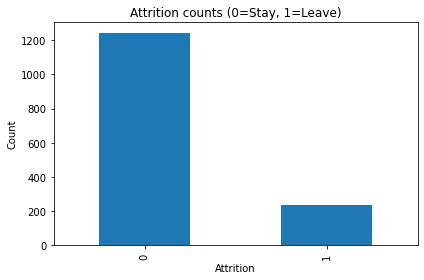

In [24]:
# Plot attrition counts
plt.figure()
pd.Series(y).value_counts().sort_index().plot(kind="bar")
plt.title("Attrition counts (0=Stay, 1=Leave)")
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("reports/attrition_count.png")
plt.show()

In [25]:
def plot_rate_by_col(col):
    if col not in X.columns:
        return
    tmp = pd.DataFrame({"col": X[col].astype(str), "y": y})
    rate = tmp.groupby("col")["y"].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,3))
    rate.plot(kind="bar")
    plt.title(f"Attrition rate by {col}")
    plt.ylabel("Mean(Attrition)")
    plt.tight_layout()
    plt.savefig(f"reports/attrition_by_{col}.png")
    plt.show()

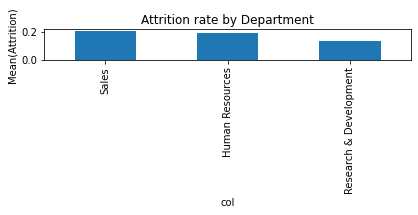

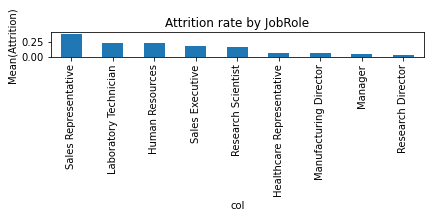

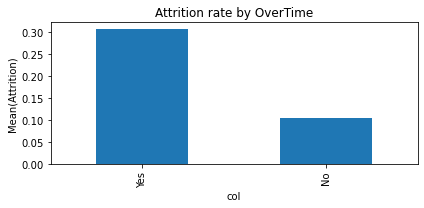

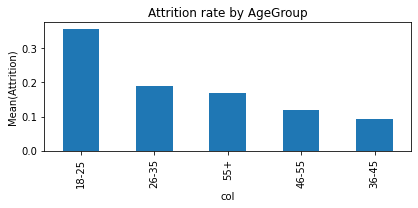

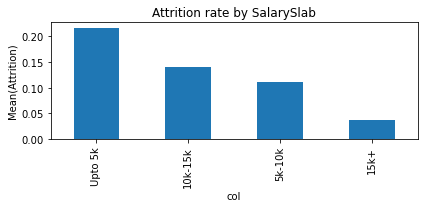

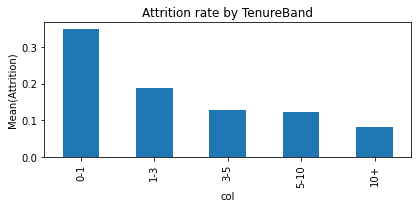

In [26]:
for col in ["Department", "JobRole", "OverTime", "AgeGroup", "SalarySlab", "TenureBand"]:
    plot_rate_by_col(col)

<Figure size 432x288 with 0 Axes>

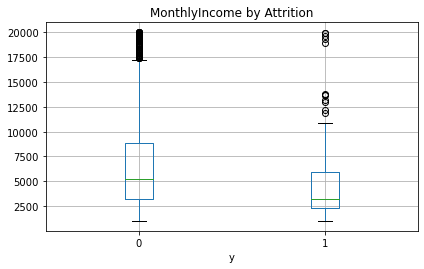

<Figure size 432x288 with 0 Axes>

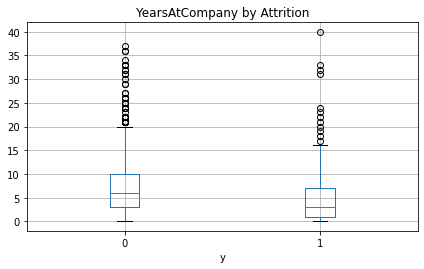

<Figure size 432x288 with 0 Axes>

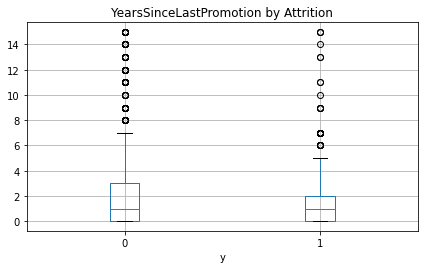

<Figure size 432x288 with 0 Axes>

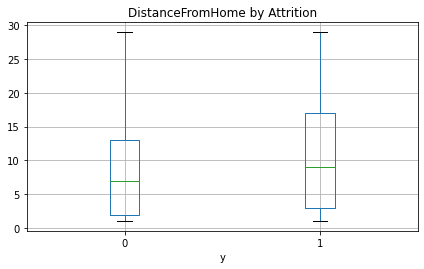

In [27]:
# Numeric relationships (boxplots)
def box_by_target(col):
    if col not in X.columns:
        return
    plt.figure()
    pd.DataFrame({"x": X[col], "y": y}).boxplot(column="x", by="y")
    plt.title(f"{col} by Attrition")
    plt.suptitle("")
    plt.tight_layout()
    plt.savefig(f"reports/box_{col}.png")
    plt.show()

for col in ["MonthlyIncome","YearsAtCompany","YearsSinceLastPromotion","DistanceFromHome"]:
    box_by_target(col)

In [28]:
# 6) Train / Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (1184, 36) (296, 36)


In [29]:
# 7) Preprocessing pipeline
# Use StandardScaler for numeric, OneHotEncoder for categorical. OneHotEncoder sparse=False for easier inspection.
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols)
], remainder="drop")

In [30]:
# 8) Baseline models (Logistic Regression and Decision Tree)
logpipe = Pipeline([("pre", preprocessor), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
treepipe = Pipeline([("pre", preprocessor), ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE, min_samples_leaf=20, max_depth=6))])

In [31]:
models = {"LogisticRegression": logpipe, "DecisionTree": treepipe}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    if hasattr(pipe, "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
    else:
        # For classifiers without predict_proba fallback to decision path (rare)
        y_prob = pipe.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC:", average_precision_score(y_test, y_prob))


=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.961     0.802     0.875       248
           1      0.449     0.833     0.584        48

    accuracy                          0.807       296
   macro avg      0.705     0.818     0.729       296
weighted avg      0.878     0.807     0.828       296

ROC-AUC: 0.8977654569892474
PR-AUC: 0.7506411201197688

=== DecisionTree ===
              precision    recall  f1-score   support

           0      0.889     0.742     0.809       248
           1      0.281     0.521     0.365        48

    accuracy                          0.706       296
   macro avg      0.585     0.631     0.587       296
weighted avg      0.790     0.706     0.737       296

ROC-AUC: 0.6729250672043011
PR-AUC: 0.4160128488778451


In [32]:
# 9) Tune Logistic Regression (GridSearchCV on C)
param_grid = {"clf__C": [0.1, 0.3, 1, 3, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(logpipe, param_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=0, refit=True)
grid.fit(X_train, y_train)
best = grid.best_estimator_
print("Best params (LogReg):", grid.best_params_)

Best params (LogReg): {'clf__C': 0.1}


In [33]:
# Evaluate tuned model
y_prob = best.predict_proba(X_test)[:, 1]
y_pred_default = best.predict(X_test)
print("\n=== Tuned Logistic Regression (default 0.5 threshold) ===")
print(classification_report(y_test, y_pred_default, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))


=== Tuned Logistic Regression (default 0.5 threshold) ===
              precision    recall  f1-score   support

           0      0.962     0.823     0.887       248
           1      0.476     0.833     0.606        48

    accuracy                          0.824       296
   macro avg      0.719     0.828     0.747       296
weighted avg      0.883     0.824     0.841       296

ROC-AUC: 0.8940692204301075
PR-AUC: 0.756101530021442


In [34]:
 # 10) Choose threshold by maximizing F1 on validation (use PR curve thresholds)
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
# thresholds length = len(prec)-1 ; compute f1 for each threshold
f1_scores = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5
print("Best threshold by F1 on test set (approx):", best_threshold)


Best threshold by F1 on test set (approx): 0.7337160459506444



=== Tuned Logistic Regression (thresholded) ===
              precision    recall  f1-score   support

           0      0.940     0.956     0.948       248
           1      0.750     0.688     0.717        48

    accuracy                          0.912       296
   macro avg      0.845     0.822     0.833       296
weighted avg      0.910     0.912     0.911       296



<Figure size 288x216 with 0 Axes>

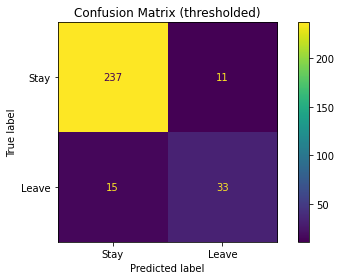

In [35]:
y_pred_thr = (y_prob >= best_threshold).astype(int)
print("\n=== Tuned Logistic Regression (thresholded) ===")
print(classification_report(y_test, y_pred_thr, digits=3))
cm = confusion_matrix(y_test, y_pred_thr)
disp = ConfusionMatrixDisplay(cm, display_labels=["Stay", "Leave"])
plt.figure(figsize=(4,3))
disp.plot(values_format="d")
plt.title("Confusion Matrix (thresholded)")
plt.tight_layout()
plt.savefig("reports/confusion_matrix_thresholded.png")
plt.show()

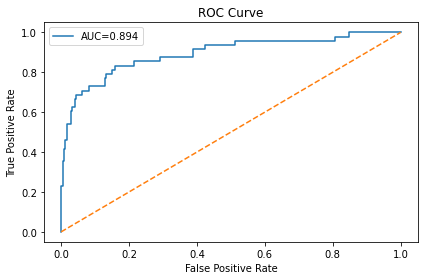

In [36]:
# Save ROC and PR curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("reports/roc_curve.png")
plt.show()

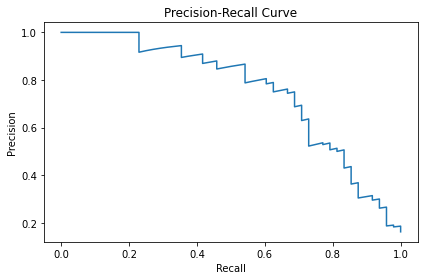

In [37]:
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.savefig("reports/pr_curve.png")
plt.show()

In [38]:
# 11) Feature names (after preprocessing) — useful for feature importance and SHAP
pre = best.named_steps["pre"]  # fitted ColumnTransformer
# Build feature name list:
ohe = pre.named_transformers_["cat"]
try:
    # sklearn >= 1.0
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
except Exception:
    # fallback for older sklearn
    cat_feature_names = []
    # attempt to reconstruct names (less pretty)
    for c in cat_cols:
        categories = ohe.categories_[cat_cols.index(c)]
        for cat in categories:
            cat_feature_names.append(f"{c}__{cat}")

feature_names = list(num_cols) + cat_feature_names
print("Total features after encoding:", len(feature_names))

Total features after encoding: 69


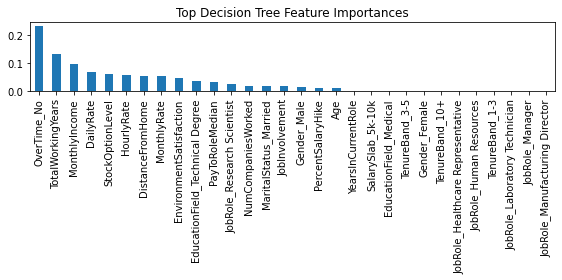

In [39]:
# 12) Decision Tree feature importance (if you want an interpretable tree)
if "DecisionTree" in models:
    tree_model = treepipe.fit(X_train, y_train).named_steps["clf"]
    # get feature importances via preprocessor transform
    X_dummy = pre.transform(X_train)
    importances = tree_model.feature_importances_
    if len(importances) == len(feature_names):
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:30]
        plt.figure(figsize=(8,4))
        fi.plot(kind="bar")
        plt.title("Top Decision Tree Feature Importances")
        plt.tight_layout()
        plt.savefig("reports/tree_feature_importances.png")
        plt.show()

SHAP plotting failed: set_ticks() got an unexpected keyword argument 'fontsize'


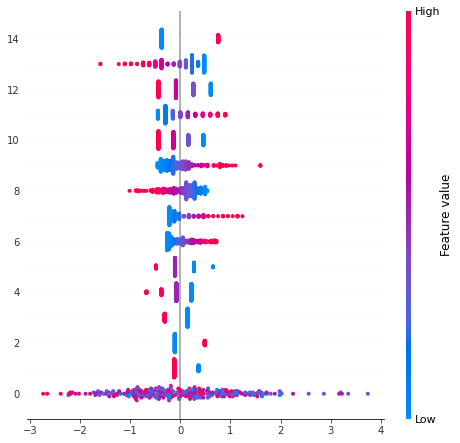

In [40]:
# 13) SHAP explainability (if installed)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False
    print("SHAP not installed — skip SHAP steps (pip install shap to enable")
import shap
clf = best.named_steps["clf"]
# Transform train/test to preprocessed arrays
X_train_trans = pre.transform(X_train)
X_test_trans = pre.transform(X_test)
# Convert sparse to dense if needed
if hasattr(X_train_trans, "toarray"):
        X_train_trans = X_train_trans.toarray()
        X_test_trans = X_test_trans.toarray()
try:
    # Use the general Explainer (works for many model types)
    explainer = shap.Explainer(clf, X_train_trans, feature_names=feature_names)
    shap_values = explainer(X_test_trans)
    # Summary beeswarm
    plt.figure()
    shap.plots.beeswarm(shap_values, max_display=15, show=False)
    plt.tight_layout()
    plt.savefig("reports/shap_beeswarm.png")
    plt.show()
except Exception as e:
        print("SHAP plotting failed:", e)
else:
    print("SHAP not available — install with: pip install shap")

In [41]:
pip install --upgrade typing_extensions shap

Note: you may need to restart the kernel to use updated packages.


In [42]:
# 14) Score & export for Power BI / HR
scores_df = X_test.copy()
scores_df = scores_df.reset_index(drop=True)
scores_df["Attrition_Prob"] = y_prob
scores_df["Predicted_Attrition"] = y_pred_thr
# Keep some context columns if exist
context = [c for c in ["Department","JobRole","MonthlyIncome","OverTime","YearsAtCompany","JobSatisfaction","WorkLifeBalance"] if c in scores_df.columns]
export_df = scores_df[context + ["Attrition_Prob","Predicted_Attrition"]]
export_path = "artifacts/employee_attrition_scores.csv"
export_df.to_csv(export_path, index=False)
print("Saved scored table to:","C:/Users/vpriy/artifacts" )
display(export_df.head(10))

Saved scored table to: C:/Users/vpriy/artifacts


,Department,JobRole,MonthlyIncome,OverTime,YearsAtCompany,JobSatisfaction,WorkLifeBalance,Attrition_Prob,Predicted_Attrition
0,Research & Development,Research Scientist,3505,No,2,3,3,0.334235,0
1,Research & Development,Manager,11878,No,10,2,3,0.334409,0
2,Research & Development,Research Scientist,4087,No,6,1,2,0.267610,0
3,Research & Development,Laboratory Technician,2270,No,5,4,3,0.021178,0
4,Research & Development,Manufacturing Director,5993,No,7,3,4,0.027216,0
5,Sales,Sales Executive,7991,No,2,2,3,0.667233,0
6,Research & Development,Research Scientist,4869,No,4,3,2,0.100442,0
7,Research & Development,Research Director,13603,Yes,5,4,3,0.063401,0
8,Research & Development,Healthcare Representative,6870,No,3,2,1,0.241789,0
9,Research & Development,Manufacturing Director,4011,No,4,3,2,0.034399,0


In [43]:
# 15) Save model & artifacts
joblib.dump(best, "artifacts/best_logistic_model.pkl")
print("Saved best model to artifacts/best_logistic_model.pkl")

Saved best model to artifacts/best_logistic_model.pkl


In [44]:
# 16) Final summary
print("\n--- Summary ---")
print("Best logistic params:", grid.best_params_)
print("Saved artifacts: reports/* and artifacts/*")
print("Open 'reports' to view confusion matrix, ROC/PR curves and optional SHAP plot.")


--- Summary ---
Best logistic params: {'clf__C': 0.1}
Saved artifacts: reports/* and artifacts/*
Open 'reports' to view confusion matrix, ROC/PR curves and optional SHAP plot.
